# Survival Analysis I: Univariate Models
### with Implementation in Python

<i>Patrick White</i></br>
<i>Dec 08, 2024</i>

<img src="img/sa1.png" style="height: 400px; width:auto;">

# Outline

- What is Survival Analysis?
- Censoring
- The Survival and Hazard Functions
- The Kaplan-Meier (KM) Estimator
- The German Breast Cancer Study (GBSG) Dataset
- Exploratory Data Analysis
- Kaplan-Meier Implementation
- Log-Rank Test for Difference Between Groups
- The Nelson-Aalen (NA) Estimator
- Univariate Parametric Models

# What is Survival Analysis?

Survival analysis is the study of survival times and the factors that influence them. It is a statistical method to investigate the amount of time expected before an event of interest occurs for a subject, and though commonly applied to medical research, there are a variety of practical applications in additional domains such as business, economics and engineering.

This series of articles will examine the concepts, measurements, and models involved in survival analysis. The first will introduce the basic concepts, and the non-parametric Kaplan-Meier (KM) and Nelson-Aalen (NA) models, as well as univariate parametric models. The second will discuss semi-parametric and parametric alternatives which incorporate covariates, and the third will discuss ensemble-based methods. Following this article, model-scoring methods will be introduced, and overfitting will be avoided through train/test splits and cross-validation.

# Censoring

The key challenge in survival analysis is censoring, meaning that the time of event is unknown for some individual. This largely prevents the application of traditional probabilistic methods, and so specialized methods have been developed.

The most commonly encountered type of censoring is right-censoring, meaning a subject’s survival time is greater than the observed duration of the study. Also common is random-censoring, examples of which in a medical study would include patient dropout, loss of contact, or death to an illness unrelated to the study. Left-censored data refers to an unavailability of data at the start of the timeline, e.g., if the start date of an illness is unknown; and interval-censored data refers to data in which the survival duration of an individual cannot be defined for some time-interval.

# The Survival and Hazard Functions

The survival function describes the probability of surviving up to a point $t$. Given a survival curve, we compute the expected remaining lifetime as a function of current age.

$S(t) = P(T \gt t)$

It has the properties that $S(0)=1$ and $S(\infty)=0$. 

The hazard function is the instantaneous failure rate - the probability that, given a subject has survived up to time $t$, that subject will fail in the next small interval of time.

$h(t) = \lim \limits_{\delta \rightarrow 0} \frac{ P(t \lt T \lt t + \delta | T \gt t) }{ \delta }$

The cumulative risk function is also right-continuous, and is the complement of the survival function.

$F(t) = P(T \lt t), 0 \lt t \lt \infty$

The risk function is the probability density function (PDF) associated with this cumulative distribution function (CDF).

$f(t) = \frac{d}{dt} F(t) = - \frac{d}{dt} S(t)$

The hazard function is related to the PDF (risk function) and survival functions by:

$h(t) = \frac{f(t)}{S(t)}$

In other words, the hazard at time $t$ is the probability that an event occurs in the neighborhood of time $t$ divided by the probability that the subject has survived until time $t$.

The cumulative hazard function is:

$H(t) = \displaystyle \int_0^t h(u) ~du$

The survival function may be defined in terms of the cumulative hazard function by:

$S(t) = exp(-H(t)) = exp \left( - \displaystyle \int_0^t h(u) ~du \right)$

# The Kaplan-Meier (KM) Estimator

The KM estimator is the most common non-parametric survival analysis technique, and provides a stepwise estimate of the survival function by progressively updating the survival probability at each observed event time. It is also referred to as the product-limit estimator, as the survival function is calculated as a cumulative product of survival probabilities at each event time $t_i$, and the estimator accommodates right-censored data by treating censored observations as ‘limits’ to the information they provide.

$\hat{S}(t) = \displaystyle \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$

- $\hat{S}(t)$ is the estimate of survival to time point $t$ and beyond
- $t_i$ is the time point when at least one event happened
- $d_i$ is the number of events occurring at time $t_i$
- $n_i$ is the number of surviving subjects at time $t_i$

By using the at-risk group in the denominator of the survival probability calculation, censored individuals contribute to the estimate up until the time they were censored, but without influencing the the survival probability beyond their censoring time.

# The German Breast Cancer Study (GBSG) Dataset

The dataset we’ll examine throughout this series of articles contains data on patients with primary node-positive breast cancer, and describes the time from surgery to reoccurrence or death related to the illness. It is available in both of the Python libraries we will be utilizing for survival functions, as <code>load_gbsg2()</code>. Fields include:

- <code>age</code> (numeric): age of patient at time of surgery
- <code>menostat</code> (“Pre” or “Post”): menopausal status of the patient
- <code>tsize</code> (numeric): tumor size in mm
- <code>tgrade</code> (ordinal): compositional grade of the tumor (higher values suggest more aggressive cancer)
- <code>pnodes</code> (numeric): number of positive lymph nodes (higher values suggest worse prognosis)
- <code>progrec</code> (numeric): progesterone receptor level, a measure of hormone receptor expression
- <code>estrec</code> (numeric): estrogen receptor level
- <code>horTh</code> (“yes” or “no”): whether the patient received hormone therapy
- <code>time</code> (numeric): number of days from the start of study to the date of an event
- <code>cens</code> (binary): 1 if the patient experienced recurrence or death

Let’s import some basic Python libraries for later, and then take a peek at the data.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loading from <code>lifelines</code>, we see the format of a standard dataframe.

In [2]:
from lifelines.datasets import load_gbsg2
data = load_gbsg2()
data.head()

,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


Loading from scikit-survival, we are returned two variables: a dataframe of ‘X’ variables, excluding time and cens, and a ‘structured array’ of the <code>time</code> and <code>cens</code> variables. Viewing the <code>X</code> dataframe:

In [3]:
from sksurv.datasets import load_gbsg2
X, y = load_gbsg2()
X.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


Viewing the first 10 rows of the <code>y</code> structured array:

In [4]:
y[0:10]

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.)],
      dtype=[('cens', '?'), ('time', '<f8')])

To put the scikit-survival format into that of a regular dataframe, and concatenate it with the <code>X</code> variable to match the data provided by <code>lifelines</code>, we would use the following:

In [5]:
data = X.copy()
data['time'] = y['time']
data['cens'] = y['cens']

And to convert the <code>time</code> and <code>cens</code> columns of a regular dataframe to the scikit-survival format, we could use the following:

In [6]:
from sksurv.util import Surv
y_converted = Surv.from_arrays(data['cens'], data['time'])

# Exploratory Data Analysis

We’ll use the data provided by scikit-survival, and start by replacing the labels in text columns with numerical labels.

In [7]:
X['horTh'] = X['horTh'].map({'yes': 1, 'no': 0})
X['menostat'] = X['menostat'].map({'Post': 1, 'Pre': 0})
X['tgrade'] = X['tgrade'].map({'I': 1, 'II': 2, 'III': 3})

To get an idea of what the data look like, we’ll plot the distributions of each variable, using records that correspond to an event being experienced.

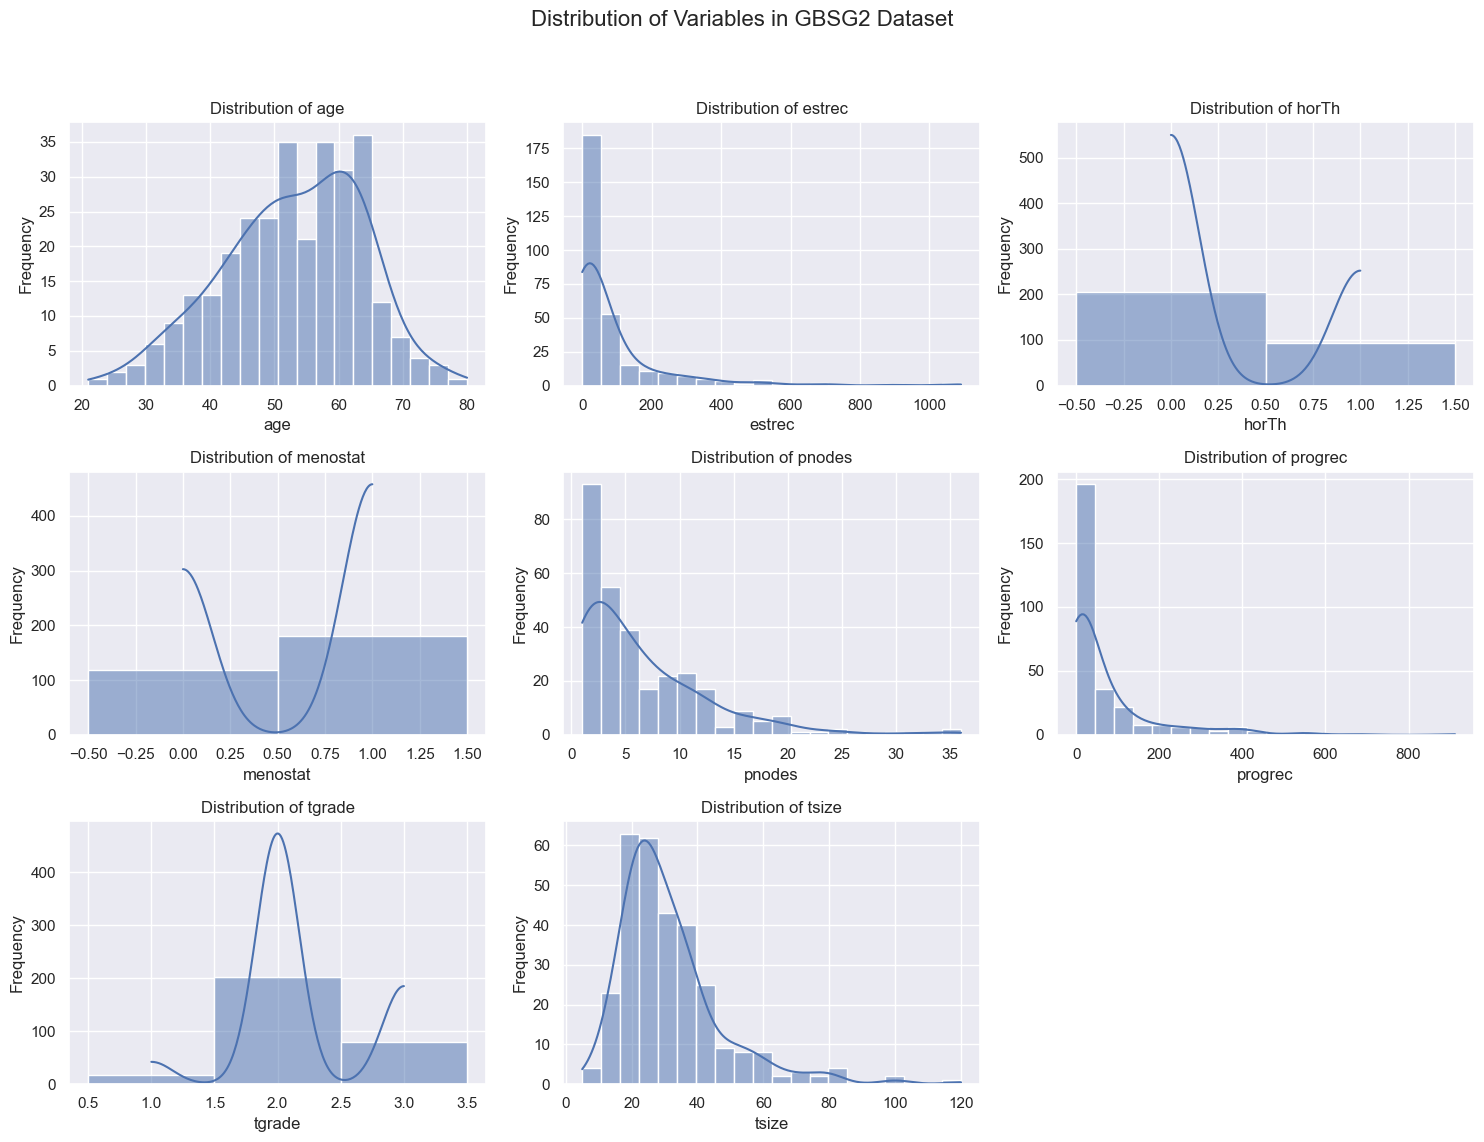

In [8]:
import warnings
warnings.filterwarnings('ignore')

data_event = X[y['cens'] == 1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Distribution of Variables in GBSG2 Dataset", fontsize=16)
axes = axes.flatten()
for i, col in enumerate(data_event.columns):
    sns.histplot(data_event[col], kde=True, ax=axes[i], bins=20)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Kaplan-Meier Implementation

We’ll use the <code>sksurv</code> implementation of the Kaplan-Meier estimator, which returns a series of unique times, the survival probability at each time point, and the lower and upper bounds of a confidence interval. 

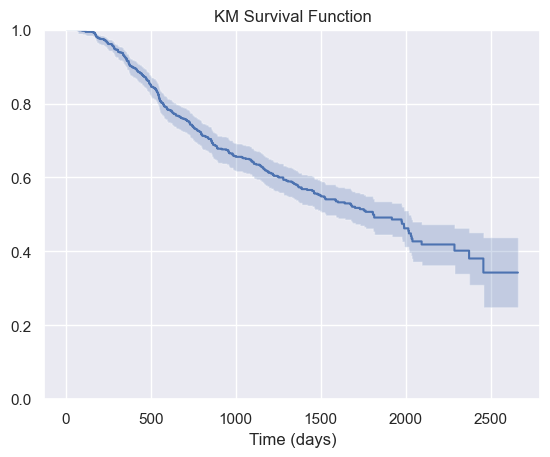

In [9]:
from sksurv.nonparametric import kaplan_meier_estimator

event = y['cens']
time = y['time']
x, y_, conf_int = kaplan_meier_estimator(event, time, conf_type="log-log")

plt.step(x, y_, where="post")
plt.fill_between(x, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.title('KM Survival Function')
plt.xlabel('Time (days)')
plt.ylim(0, 1)
plt.show()

The survival function produced is univariate, i.e., we aren’t yet taking any covariates into account. To get around this, we could run multiple KM models, one for each level (or bin) of a covariate. Below, we plot a KM model for each level in our categorical variables.

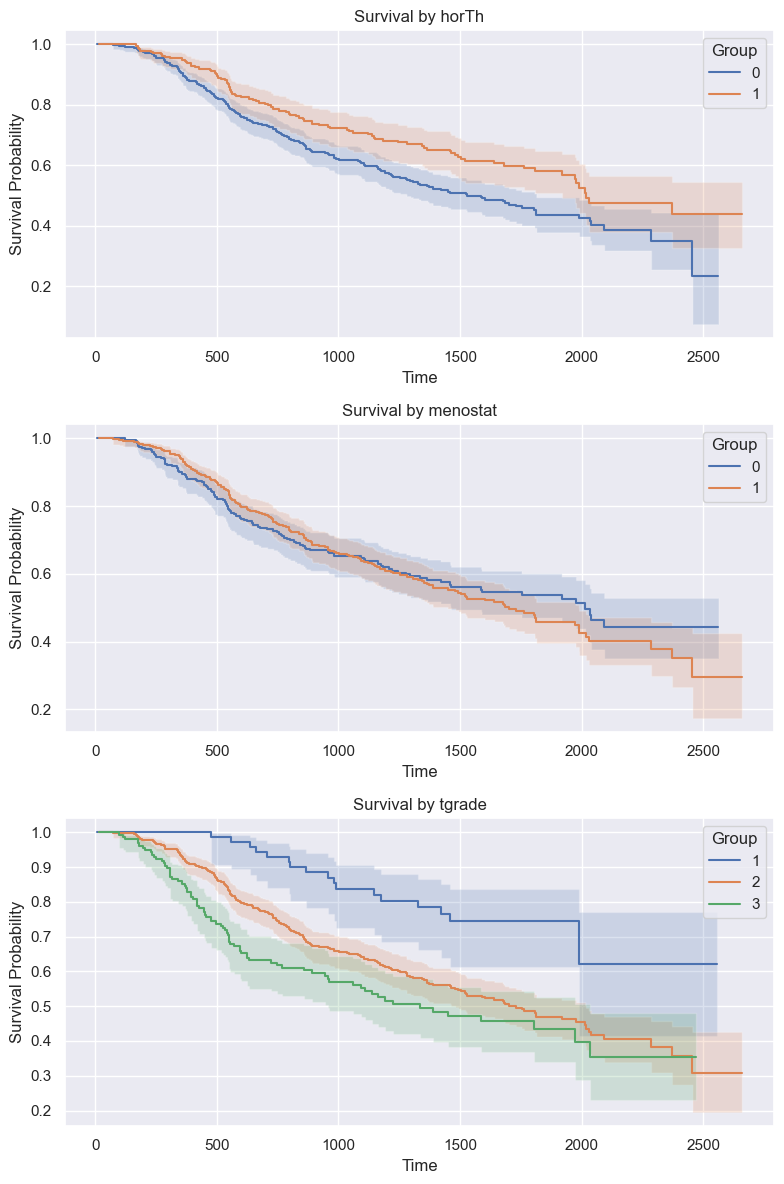

In [10]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

def plot_km(ax, time, event, group_data, title):
    unique_groups = np.unique(group_data)
    for group in unique_groups:
        mask = group_data == group
        times, survival_prob, confint = kaplan_meier_estimator(event[mask], time[mask], conf_type="log-log")
        lower = confint[0]
        upper = confint[1]
        ax.step(times, survival_prob, where="post", label=f"{group}")
        ax.fill_between(times, lower, upper, step="post", alpha=0.2)
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("Survival Probability")
    ax.legend(title="Group")

plot_km(axes[0], time, event, X['horTh'], "Survival by horTh")
plot_km(axes[1], time, event, X['menostat'], "Survival by menostat")
plot_km(axes[2], time, event, X['tgrade'], "Survival by tgrade")

plt.tight_layout()
plt.show()

# Log-Rank Test for Differences Between Groups

To test quantitatively for significant differences in survival experience between groups, we can use the non-parametric log-rank test upon the observed data. It compares the observed number of events in each group to the expected number of events under the null hypothesis that the survival functions are the same across groups.

The test statistic follows a Chi-Squared distribution with degrees of freedom equal to the number of groups minus one. A large value corresponds to a low p-value, which suggests significant difference between groups. 

For groups denoted $i$ and times denoted $j$,

$\chi^2 = \frac{ \sum_{j=1}^J (O_{i,j} - E_{i,j}) }{ \sqrt \sum_{i=1}^n V_{i,j} }$

where $E_{i,j}$ is an expected value term:

$E_{i,j} = O_j \frac{N_{i,j}}{N_j}$

and $V_{i,j}$ is a variance term:

$V_{i,j} = E_{i,j} \left( \frac{N_j - O_j}{N_j} \right) \left( \frac{N_j - N_{i,j}}{N_j - 1} \right)$

We’ll use the <code>lifelines</code> implementation of the test to examine differences between groups for the same factors and levels examined above, and compare the results.

In [12]:
from lifelines import statistics

def logrank_test_results(data, variable):
    unique_levels = data[variable].unique()
    results = []

    # Perform log-rank test for each pairwise combination of levels
    for i, level_1 in enumerate(unique_levels):
        for j, level_2 in enumerate(unique_levels):
            if j > i:  # Only compare unique pairs
                group_1 = data[data[variable] == level_1]
                group_2 = data[data[variable] == level_2]
                logrank_result = statistics.logrank_test(
                    group_1['time'], group_2['time'],
                    event_observed_A=group_1['cens'],
                    event_observed_B=group_2['cens']
                )
                # Store result for table display
                results.append({
                    'Variable': variable,
                    'Comparison': f"{level_1} vs {level_2}",
                    'Log-rank Statistic': logrank_result.test_statistic,
                    'p-value': logrank_result.p_value
                })

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Get log-rank test results for each categorical variable
horTh_results = logrank_test_results(data, 'horTh')
menostat_results = logrank_test_results(data, 'menostat')
tgrade_results = logrank_test_results(data, 'tgrade')

# Display results
print("Log-rank Test Results for horTh:")
print(horTh_results, "\n")

print("Log-rank Test Results for menostat:")
print(menostat_results, "\n")

print("Log-rank Test Results for tgrade:")
print(tgrade_results, "\n")

Log-rank Test Results for horTh:
  Variable Comparison  Log-rank Statistic   p-value
0    horTh  no vs yes            8.564781  0.003427 

Log-rank Test Results for menostat:
   Variable   Comparison  Log-rank Statistic   p-value
0  menostat  Post vs Pre             0.28019  0.596577 

Log-rank Test Results for tgrade:
  Variable Comparison  Log-rank Statistic   p-value
0   tgrade  II vs III            4.427015  0.035374
1   tgrade    II vs I           13.671903  0.000218
2   tgrade   III vs I           19.815191  0.000009 



We see low p-values for the differences between each level in each factor except for <code>menostat</code>. This makes sense, because the Kaplan-Meier survival functions were visually distinctive, aside from the levels within the menostat covariate. These two curves reside quite close to each other, and even cross paths around the mid-point of the total duration.

# The Nelson-Aalen (NA) Estimator

If we are curious about the hazard function, which is the basis of additional techniques, we cannot simply transform a KM estimate, however there is a proper non-parametric estimator of the cumulative hazard function $H(t)$: the Nelson-Aalen (NA) estimator.

$\hat{H}(t) = \displaystyle \sum_{t_i \lt t} \frac{d_i}{n_i}$

We’ll opt for the <code>lifelines</code> implementation, as it returns a confidence interval, whereas the sksurv version does not. 

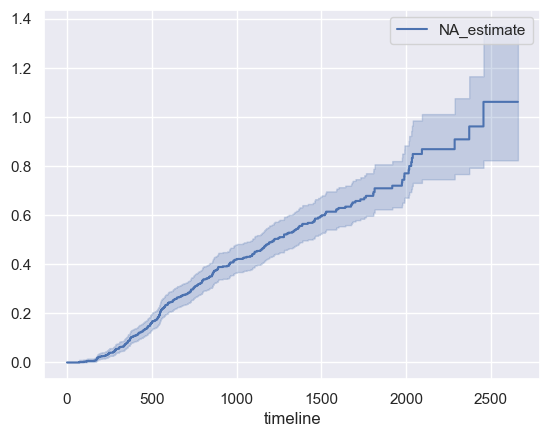

In [12]:
from lifelines import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(time,event_observed=event)
naf.plot_cumulative_hazard();

As before, the model is univariate, but we can plot (and otherwise compare) models that are filtered to particular groups.

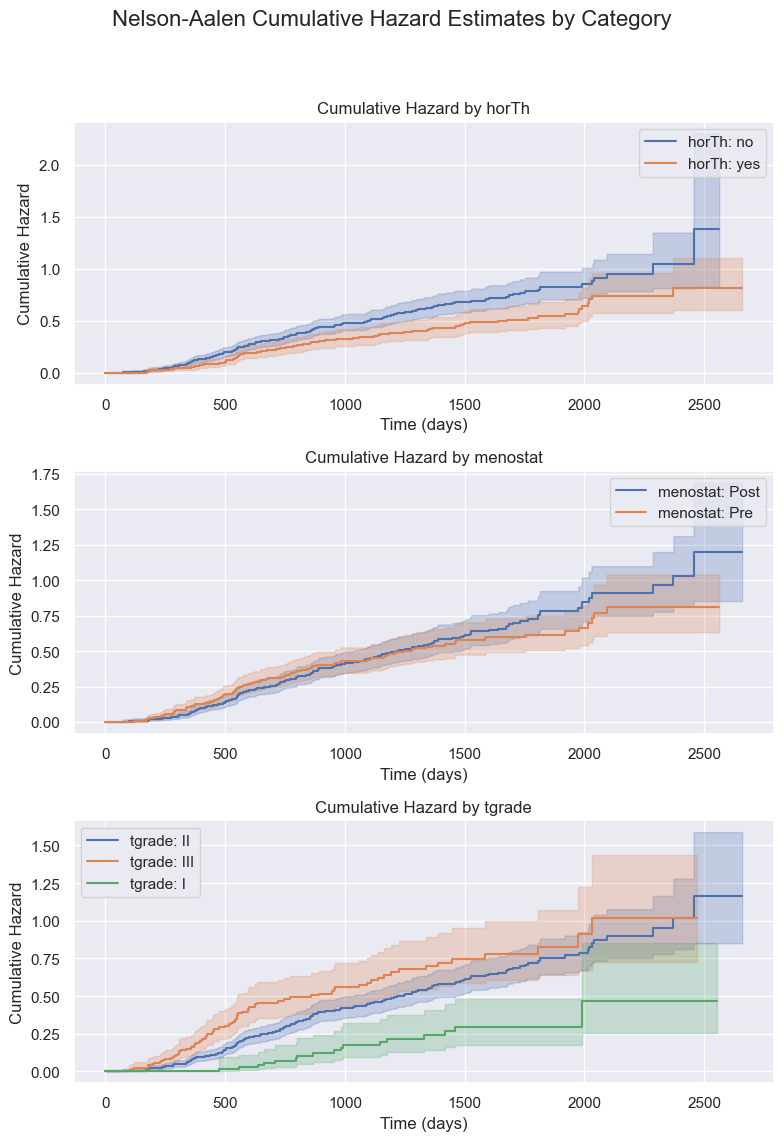

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
fig.suptitle("Nelson-Aalen Cumulative Hazard Estimates by Category", fontsize=16)

naf = NelsonAalenFitter()

for level in data['horTh'].unique():
    mask = data['horTh'] == level
    naf.fit(data['time'][mask], event_observed=data['cens'][mask], label=f"horTh: {level}")
    naf.plot(ax=axes[0])
axes[0].set_title("Cumulative Hazard by horTh")
axes[0].set_xlabel("Time (days)")
axes[0].set_ylabel("Cumulative Hazard")

for level in data['menostat'].unique():
    mask = data['menostat'] == level
    naf.fit(data['time'][mask], event_observed=data['cens'][mask], label=f"menostat: {level}")
    naf.plot(ax=axes[1])
axes[1].set_title("Cumulative Hazard by menostat")
axes[1].set_xlabel("Time (days)")
axes[1].set_ylabel("Cumulative Hazard")

for level in data['tgrade'].unique():
    mask = data['tgrade'] == level
    naf.fit(data['time'][mask], event_observed=data['cens'][mask], label=f"tgrade: {level}")
    naf.plot(ax=axes[2])
axes[2].set_title("Cumulative Hazard by tgrade")
axes[2].set_xlabel("Time (days)")
axes[2].set_ylabel("Cumulative Hazard")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Univariate Parametric Models

We’re not quite done yet. We’ve covered non-parametric models, and before proceeding to the next article, which will examine parametric and semi-parametric methods of survival regression, we’ll touch upon the other type of univariate model, vanilla parametric ones. In later articles, we’ll see the same distribution families utilized, but incorporating covariates.

As with regular probability analysis, parametric distributions have the pleasant property that a summary statistic or two will provide complete information about a distribution, given its analytical form. Popular parametric models for survival analysis include the Exponential, Weibull, Log-Normal, Log-Logistic, and generalized Gamma. Piecewise and spline-based models are also available.

### Exponential:

The Exponential model reflects inter-arrival times in a Poisson process, and its univariate distribution has the form:

$S(t) = \exp\left(\frac{-t}{\lambda}\right),   \lambda \gt 0$

with cumulative hazard

$H(t) = \frac{t}{\lambda}$

and hazard rate

$h(t) = \frac{1}{\lambda}$

### Weibull:

The Weibull is a generalization of the Exponential; the Exponential is equivalent to a Weibull with shape parameter $\rho=1$.

$S(t) = \exp\left(-\left(\frac{t}{\lambda}\right)^\rho\right),   \lambda \gt 0, \rho \gt 0$

$H(t) = \left(\frac{t}{\lambda}\right)^\rho$

$h(t) = \frac{\rho}{\lambda}\left(\frac{t}{\lambda}\right)^{\rho-1}$

### Log-Normal

The Log-Normal distribution arises when the logarithm of a random variable follows a Normal distribution, and is associated with multiplicative error.

$S(t) = 1 - \Phi\left(\frac{\log(t) - \mu}{\sigma}\right),  \;\; \sigma \gt 0$

$H(t) = -\log\left(1 - \Phi\left(\frac{\log(t) - \mu}{\sigma}\right)\right)$

where $\Phi$ is the CDF of the Normal distribution.

### Log-Logistic

The Log-Logistic distribution arises in contexts where the logarithm of a random variable follows a logistic distribution, and is commonly encountered when dealing with positive-valued data that are multiplicative in nature, or grow exponentially.

$S(t) = \left(1 + \left(\frac{t}{\alpha}\right)^{\beta}\right)^{-1},   ~\alpha \gt 0, ~\beta \gt 0$

$H(t) = \log\left(\left(\frac{t}{\alpha}\right) ^ {\beta} + 1\right)$

$h(t) = \frac{\left(\frac{\beta}{\alpha}\right)\left(\frac{t}{\alpha}\right) ^ {\beta-1}}{\left(1 + \left(\frac{t}{\alpha}\right)^{\beta}\right)}$

The generalized Gamma has the Exponential, Weibull, Gamma, and Log-Normal as sub-models, and can be read about in the <a href="https://lifelines.readthedocs.io/en/latest/fitters/univariate/GeneralizedGamma.html">lifelines documentation</a>. Piecewise and spline-based models are also available. 

We’ll run each of the above-mentioned models upon our data, and take a look at the results. For the most part, they produce very similar predictions.

In [19]:
def convert_to_lifelines_format(sksurv_y):
    time = sksurv_y['time']
    cens = sksurv_y['cens']
    lifelines_df = pd.DataFrame({
        'time': time,
        'cens': cens
    })
    return lifelines_df

y = convert_to_lifelines_format(y)

<Axes: >

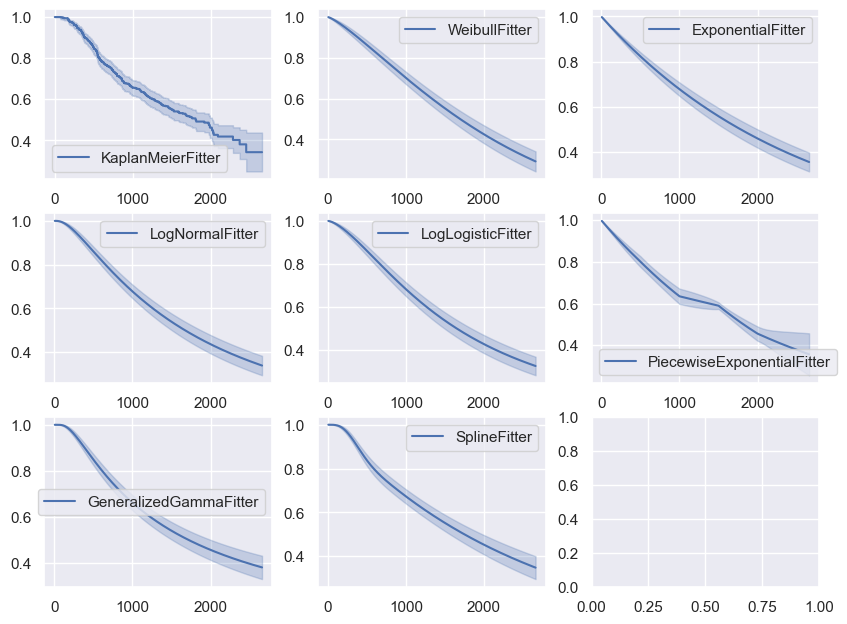

In [20]:
from lifelines import KaplanMeierFitter
from lifelines import ExponentialFitter
from lifelines import WeibullFitter
from lifelines import LogLogisticFitter
from lifelines import LogNormalFitter
from lifelines import GeneralizedGammaFitter
from lifelines import SplineFitter
from lifelines import PiecewiseExponentialFitter

fig, axes = plt.subplots(3, 3, figsize=(10, 7.5))

T = y['time']
E = y['cens']

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([500,1000,1500,2000]).fit(T, E, label='PiecewiseExponentialFitter')
ggf = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
knots = np.percentile(y['time'].loc[y['cens'].astype(bool)], [0,33,66])
spf = SplineFitter(knots).fit(T, E, label='SplineFitter')

kmf.plot_survival_function(ax=axes[0][0])
wbf.plot_survival_function(ax=axes[0][1])
exf.plot_survival_function(ax=axes[0][2])
lnf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
ggf.plot_survival_function(ax=axes[2][0])
spf.plot_survival_function(ax=axes[2][1])

And with that, we’ll wrap it up. Next article will deal with survival regression methods, and the following one with ensemble-based methods such as random survival forests and gradient-boosting.

# References

- (n.d.). Lifelines Documentation. Lifelines. https://lifelines.readthedocs.io/en/latest/

- (n.d.). Scikit-Survival Documentation. https://scikit-survival.readthedocs.io/en/stable/user_guide/index.html

- Moore, D. F. (2016). Applied Survival Analysis in R. Springer International Publishing Switzerland 2016.

- [Udemy]. (2019, April 1). Survival Analysis in R [Video]. Udemy. 